# Step 3 Calculating interaction of randomly generated particles in 3D space

In [1]:
import numpy as np
from scipy.special import lpmn, factorial
from multipole import Vlm
from multipole import operation as op

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')
def plot_3d(x):
    """plot particles in 3 dimentional"""
    y = np.transpose(x)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y[0], y[1], y[2])
    ax = ax.view_init(30)
    plt.show()
    return 

In [3]:
#case 3.1 construction: random particles
num_particles = 100
x_i = np.ndarray(shape=(3, num_particles))
x_i[0] = 20 * np.random.rand(num_particles) - 10
x_i[1] = 20 * np.random.rand(num_particles) - 10
x_i[2] = 20 * np.random.rand(num_particles) - 10
x_i = np.transpose(x_i)
q = np.ones(num_particles)

In [4]:
#case 3.2 construction: nearly uniform distributed particles:
num_particles_in_a_box = 1
num_particels_1D = 3
num_particles = num_particles_in_a_box * num_particels_1D **3
X = np.zeros(shape=(num_particles,3))

for i in range(0,num_particels_1D):
    for j in range(0,num_particels_1D):
        for k in range(0,num_particels_1D):
            X[i*num_particels_1D*num_particels_1D+j*num_particels_1D+k] = [i,j,k] 

q = np.ones(num_particles)

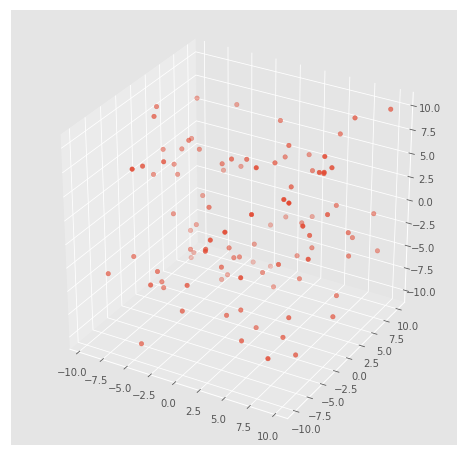

In [4]:
plot_3d(x_i)

In [6]:
[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)

import timeit

start = timeit.default_timer()

[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)

stop = timeit.default_timer()

print(stop - start) 

In [7]:
# analytical answer
pair_potential = np.zeros(shape=(num_particles,num_particles)) 
for i in range(0, num_particles):
    for j in range(i+1, num_particles):
        pair_potential[i][j] = 1 / (op.distance_cal(x0_i[i], x0_i[j]) * scale_factor[1])
        
pair_potential

array([[0.        , 0.13149745, 0.18322167, ..., 0.05851282, 0.0824909 ,
        0.08769578],
       [0.        , 0.        , 0.09848912, ..., 0.1008286 , 0.21231232,
        0.12815023],
       [0.        , 0.        , 0.        , ..., 0.05493495, 0.06782206,
        0.09534636],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.15177962,
        0.08111382],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09896477],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [8]:
J_analytic = np.zeros(num_particles)
for i in range(0, num_particles):
    for j in range(0, num_particles):
        if j<i:
            J_analytic[i] += pair_potential[j][i]
        if j>i:
            J_analytic[i] += pair_potential[i][j]

J_analytic

array([ 6.60098813,  8.44450626,  7.65343856, 10.74096782,  9.79271069,
        7.23920534,  9.09920313,  9.49822029, 10.01060929,  7.98449427,
        8.50245036,  7.44589654,  9.99688908,  9.35237022, 10.46942563,
        8.59991812,  9.8498959 ,  9.14261755,  8.48270042,  9.66463602,
        9.31058556,  8.62191621,  8.291073  , 10.41764256,  9.88748533,
        8.03636332,  8.26800005,  7.72516737, 10.52814685,  8.77576125,
       10.45179578,  9.85398589,  8.05406303, 10.48550356,  7.6805524 ,
        9.368629  ,  9.18442788,  7.21971274, 10.39254734, 10.67779442,
       10.00043908,  8.87718073,  7.83399939,  8.72467036,  7.34967324,
        7.31426969,  9.68009876, 10.22168589,  9.24266959, 10.08285381,
        8.82944531,  9.34148443, 10.33820306,  9.9244502 , 10.79398354,
       10.49510129,  9.82207365,  7.92902251,  7.3622533 ,  8.58640495,
       10.10389675,  7.16490595,  9.99277896, 10.35657949,  8.88599997,
        8.87967117,  8.27120321,  9.58185909, 10.90040546,  8.26

In [9]:
total_energy = 0.5 * sum(J_analytic)
total_energy

460.0164259020105

In [10]:
from multipole import fmm_level as fl
from multipole import fmm_q_source as fq

In [11]:
# build list of q_source
q_source = np.ndarray(shape=(len(x0_i)), dtype=fq) 
for i in range(0, len(x0_i)):
    q_source[i] = fq(x0_i[i], q[i])
    

In [21]:
# run the calculation:
#1 construction of boxes at each level with Olm
btm_level = 3

p = 10

ws_index = 3
f_btm_level = fl(btm_level, q_source, 5, ws_index)

f_top_level = f_btm_level
while (f_top_level.level != 1):
    print(f_top_level.level)
    f_top_level = f_top_level.lower_level_construction()
    
#2 calculation the interaction and translation the potential
print('----------')
f_level_i = f_top_level
while (f_level_i.level != f_btm_level.level):
    f_level_i.Mlm_translation_to_higher_level()
    f_level_i = f_level_i.higher_level
    print(f_level_i.level)
    f_level_i.box_interactions()
    
f_level_i.level

3
2
----------
2
3


3

In [13]:
#3 calculation of J far field
J_far_field = np.zeros(num_particles)
for i in range(0, num_particles):
    if not f_btm_level.box_list[q_source[i].box_id].Mlm:
        J_far_field[i] = 0.
    else:
        J_far_field[i] = f_btm_level.box_list[q_source[i].box_id].Mlm.product(q_source[i].Olm).sum().real 

J_far_field /= scale_factor[1]

In [14]:
J_far_field

array([ 5.33670422,  5.97834795,  5.37959086, 11.45207091,  6.04906798,
        5.9084237 ,  6.13772598,  6.52967577,  6.11416532,  5.9232682 ,
        6.24525637,  5.56989763, 12.71297705,  6.12051519,  5.94292823,
        5.59615512, 11.93420407,  5.83681315,  6.29151666,  5.56505239,
        6.23767326,  6.6497339 ,  6.79349663,  6.05627647,  6.85374974,
        5.5243988 ,  5.98282817,  5.71339872,  6.18082575,  6.15210601,
        6.30433329,  6.09839861,  5.62543159,  7.01552657,  6.44432486,
        5.87609472,  6.4152037 , 11.25463378, 13.94342744, 17.43423337,
        5.81050792,  5.73915754,  5.67408742,  6.25795602,  5.91564403,
        6.1468673 ,  5.44686901,  6.3546013 ,  5.98712464,  6.13244622,
        5.54628444,  6.2486104 ,  5.82287389,  6.83161374,  6.80165046,
        6.21423306,  7.37942836,  5.93287339,  5.68562058,  5.85855635,
        6.5345841 ,  5.25784276, 11.8811999 ,  6.0408972 ,  6.09149999,
        5.85702577, 11.15836511,  5.86898134,  5.96682552,  5.59

In [15]:
#4 calculation of J near filed
J_near_field = np.zeros(num_particles)
for i in range(0,num_particles):
    J_near_field[i] = 0.
    for j in f_btm_level.box_list[q_source[i].box_id].q_source_id_set:
        if j == i:
            continue
        J_near_field[i] += 1  / (op.distance_cal(q_source[i].x, q_source[j].x) * scale_factor[1])
    for NN_box_id in f_btm_level.box_list[q_source[i].box_id].NN_box_id_set:
        for j in f_btm_level.box_list[NN_box_id].q_source_id_set:
            J_near_field[i] += 1  / (op.distance_cal(q_source[i].x, q_source[j].x) * scale_factor[1])

In [16]:
J_near_field

array([1.18681965, 2.22897039, 1.67541508, 4.72042603, 3.63049038,
       1.24258926, 2.60670214, 2.74122429, 3.95214404, 1.92230524,
       2.19178074, 1.64528154, 3.68541776, 3.1304723 , 4.41073408,
       2.978372  , 3.50850473, 3.07696583, 1.61315153, 3.85528256,
       3.115904  , 1.78717901, 1.74292293, 4.49822946, 2.87802934,
       2.05750978, 2.32558962, 1.76058743, 4.27944334, 1.98554691,
       3.96988003, 3.47434389, 2.42588421, 3.01642974, 1.02146451,
       3.31440509, 2.92384677, 0.86518451, 3.08609727, 4.77648779,
       3.61407591, 2.7577029 , 2.35634538, 2.38541641, 1.54773173,
       1.52281545, 4.09263786, 3.85006758, 2.76483173, 3.89630831,
       2.59009298, 2.93122427, 3.57243623, 2.77504164, 3.75301023,
       4.36463564, 2.31659476, 1.66201614, 1.61361829, 2.33056897,
       3.31378157, 1.69238488, 3.88437509, 4.0792846 , 2.59123868,
       2.98088093, 2.2238307 , 3.74208359, 4.75779392, 2.37538231,
       3.70319762, 6.11728927, 5.80541812, 2.77470487, 0.68898

In [17]:
J_total = J_far_field + J_near_field
J_total

array([ 6.52352387,  8.20731833,  7.05500594, 16.17249694,  9.67955836,
        7.15101296,  8.74442812,  9.27090006, 10.06630936,  7.84557344,
        8.43703711,  7.21517917, 16.39839481,  9.2509875 , 10.35366231,
        8.57452713, 15.4427088 ,  8.91377897,  7.90466819,  9.42033495,
        9.35357726,  8.43691291,  8.53641956, 10.55450593,  9.73177908,
        7.58190858,  8.30841779,  7.47398614, 10.46026909,  8.13765292,
       10.27421332,  9.5727425 ,  8.05131581, 10.03195631,  7.46578937,
        9.19049981,  9.33905047, 12.11981829, 17.02952471, 22.21072115,
        9.42458383,  8.49686043,  8.0304328 ,  8.64337242,  7.46337576,
        7.66968275,  9.53950687, 10.20466888,  8.75195637, 10.02875453,
        8.13637742,  9.17983467,  9.39531012,  9.60665538, 10.55466069,
       10.5788687 ,  9.69602313,  7.59488953,  7.29923887,  8.18912532,
        9.84836568,  6.95022764, 15.76557499, 10.1201818 ,  8.68273867,
        8.83790669, 13.38219581,  9.61106494, 10.72461945,  7.97

In [18]:
total_energy = 0.5 * sum(J_total)
total_energy

480.266106746139

In [19]:
J_error = np.abs(J_total-J_analytic) / J_analytic
J_error

array([1.17352516e-02, 2.80878386e-02, 7.81913410e-02, 5.05683400e-01,
       1.15547503e-02, 1.21826050e-02, 3.89896788e-02, 2.39329286e-02,
       5.56410386e-03, 1.73988270e-02, 7.69345872e-03, 3.09858411e-02,
       6.40349780e-01, 1.08403233e-02, 1.10572752e-02, 2.95246882e-03,
       5.67804265e-01, 2.50298750e-02, 6.81424785e-02, 2.52778343e-02,
       4.61750764e-03, 2.14573305e-02, 2.95916537e-02, 1.31376533e-02,
       1.57478113e-02, 5.65498009e-02, 4.88845382e-03, 3.25146646e-02,
       6.44726553e-03, 7.27125896e-02, 1.69906172e-02, 2.85410790e-02,
       3.41098068e-04, 4.32546946e-02, 2.79619256e-02, 1.90133681e-02,
       1.68352987e-02, 6.78711983e-01, 6.38628543e-01, 1.08008511e+00,
       5.75829962e-02, 4.28424642e-02, 2.50744741e-02, 9.31816703e-03,
       1.54704177e-02, 4.85917355e-02, 1.45238082e-02, 1.66479411e-03,
       5.30921525e-02, 5.36547312e-03, 7.84950666e-02, 1.73045045e-02,
       9.12047225e-02, 3.20214032e-02, 2.21718748e-02, 7.98157223e-03,
      

In [20]:
for i in range(0,len(f_btm_level.box_list)):
    if f_btm_level.box_list[i]:
        print(i)

2
13
15
21
22
41
42
44
48
58
59
67
71
81
84
85
86
95
100
103
109
112
117
123
128
130
131
136
138
148
153
155
163
169
171
173
175
183
187
188
191
197
203
214
225
233
239
245
255
268
279
283
287
288
296
306
310
313
324
325
343
357
359
360
361
362
368
372
373
380
393
398
401
417
419
420
422
429
436
440
441
446
450
463
469
472
479
480
487
511


In [47]:
index1 = 27
index2 = 465


Y = np.ndarray(shape=(4,3)) #Cartesian coordiantes of box centers
Y[0] = f_btm_level.box_list[index1].x
Y[1] = f_btm_level.box_list[index2].x
Y[2] = f_btm_level.lower_level.box_list[f_btm_level.box_id_to_lower_level(index1)].x
Y[3] = f_btm_level.lower_level.box_list[f_btm_level.box_id_to_lower_level(index2)].x

y_i = np.ndarray(shape=(2,3))
y_i[0] = q_source[0].x
y_i[1] = q_source[1].x


AttributeError: 'NoneType' object has no attribute 'x'

In [ ]:
Y

In [ ]:
analytic_potential = 0 
for i in range(0, len(y_i)):
    for j in range(i+1, len(y_i)):
        analytic_potential += 1 / op.distance_cal(y_i[i], y_i[j])

analytic_potential / scale_factor[1]

In [ ]:
# test on conversion operation
p1 = 5

r1_1 = op.cartesian_to_spherical(y_i[0] - Y[0])
Olm_q1_x1_k = op.O_expansion(p1, r1_1)

Olm_q1_x1_k.Vp

In [ ]:
q_source[0].Olm.Vp

In [ ]:
Y31 = Y[0] - Y[2]
Olm_q1_x3_k = op.O_to_O(Olm_q1_x1_k, Y31)

Olm_q1_x3_k.Vp

In [ ]:
f_btm_level.lower_level.box_list[f_btm_level.box_id_to_lower_level(index1)].Olm.Vp

In [ ]:
Y34 = Y[3] - Y[2]
Mlm_q1_x4_k = op.O_to_M(Olm_q1_x3_k, Y34)
Mlm_q1_x4_k.Vp

In [ ]:
f_btm_level.lower_level.box_list[f_btm_level.box_id_to_lower_level(index2)].Mlm.Vp

In [ ]:
Y42 = Y[1] - Y[3]
Mlm_q1_x2_k = op.M_to_M(Mlm_q1_x4_k, Y42)

Mlm_q1_x2_k.Vp

In [ ]:
f_btm_level.box_list[index2].Mlm.Vp